In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import multiprocessing
from datetime import datetime

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.feature_column import feature_column
from tensorflow.contrib.learn import learn_runner

import matplotlib.pyplot as plt

print(tf.__version__)

1.4.0


## 1. Define Command Line Parameters

In [2]:
class FLAGS():
  pass

FLAGS.model_dir = './trained_models'
FLAGS.data_dir = './mnist_data'
FLAGS.model_name = 'auto-encoder-03'
FLAGS.drop_out_rate = 0.8
FLAGS.batch_size = 100
FLAGS.num_epochs = 10
FLAGS.encoder_hidden_units = [50]
FLAGS.learning_rate = 0.01
FLAGS.l2_reg = 0.0001
FLAGS.noise_level = 0.0
FLAGS.dropout_rate = 0.1
FLAGS.resume_training = False
FLAGS.max_steps = 10000

In [3]:
mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz


## 2. Define Data Input Function

In [4]:
def generate_input_fn(mnist_data,
                      mode=tf.estimator.ModeKeys.EVAL,
                      batch_size=1):
  
  def input_fn():
    if mode == tf.estimator.ModeKeys.EVAL:
      images = mnist.validation.images
      labels = images
    elif mode == tf.estimator.ModeKeys.TRAIN:
      images = mnist.train.images
      labels = images
    else:
      assert(False)
      
    """
    images_placeholder = tf.placeholder(images.dtype, images.shape)
    labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
    dataset = tf.data.Dataset.from_tensor_slices((images_placeholder,
                                                  labels_placeholder))
    """
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    """
    if is_training:
      buffer_size = batch_size * 2 + 1
      dataset = dataset.shuffle(buffer_size=buffer_size)
    
    dataset = dataset.prefetch(2 * batch_size)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_initializable_iterator()

    with tf.Session() as sess:
      sess.run(iterator.initializer,
               feed_dict={images_placeholder: images, labels_placeholder: labels})
    images_tensor, target_tensor = iterator.get_next()
    return {'images': images_tensor}, target_tensor
    """
    return tf.estimator.inputs.numpy_input_fn(
      batch_size=batch_size,
      shuffle=is_training,
      x={'images': images},
      y=labels)
  
  return input_fn()

## 3. Define Feature Columns

In [5]:
def get_feature_columns():
  feature_columns = {
    'images': tf.feature_column.numeric_column('images', (784,))
  }
  return feature_columns

In [6]:
feature_columns = get_feature_columns()
print('Feature Columns {}'.format(feature_columns))

Feature Columns {'images': _NumericColumn(key='images', shape=(784,), default_value=None, dtype=tf.float32, normalizer_fn=None)}


## 4. Instantiate an Estimator

In [7]:
def model_fn(features, labels, mode, params):
  encoder_hidden_units = params.encoder_hidden_units
  decoder_hidden_units = encoder_hidden_units
  
  # Remove a middle unit if length of encoder hidden units exceeds 1.
  if len(encoder_hidden_units) > 1:
    decoder_hidden_units.reverse()
    decoder_hidden_units.pop(0)

  output_layer_size = 784

  he_initializer = tf.contrib.layers.variance_scaling_initializer() # ???
  l2_regularizer = tf.contrib.layers.l2_regularizer(scale=params.l2_reg)

  is_training = (mode == tf.estimator.ModeKeys.TRAIN)

  with tf.name_scope('input'):
    feature_columns = list(get_feature_columns().values())
    input_layer = tf.feature_column.input_layer(
      features=features, feature_columns=feature_columns)

  with tf.name_scope('noisy_input'):
    # Adding Gaussian Noise to input layer
    noisy_input_layer = input_layer + (
      params.noise_level * tf.random_normal(tf.shape(input_layer)))
    # Dropout layer
    dropout_layer = tf.layers.dropout(
      inputs=noisy_input_layer, rate=params.dropout_rate, training=is_training)

  with tf.name_scope('encoder'):
    # Encoder layers stack
    encoding_hidden_layers = tf.contrib.layers.stack(
      inputs=dropout_layer,
      layer=tf.contrib.layers.fully_connected,
      stack_args=encoder_hidden_units,
      weights_regularizer = l2_regularizer,
      activation_fn=tf.nn.relu)

  with tf.name_scope('decoder'):
    # Decoder layers stack
    decoding_hidden_layers = tf.contrib.layers.stack(
      inputs=encoding_hidden_layers,
      layer=tf.contrib.layers.fully_connected,
      stack_args=decoder_hidden_units,
      weights_regularizer=l2_regularizer,
      activation_fn=tf.nn.relu)

    # Output (reconstructured) layer
    output_layer = tf.layers.dense(inputs=decoding_hidden_layers,
                                   units=output_layer_size,
                                   activation=None)

    # Encoding output (i.e., extracted features) reshaped
    encoding_output = tf.squeeze(encoding_hidden_layers)

    # Reconstruction output reshaped (for loss calculation)
    reconstruction_output = tf.squeeze(output_layer)

  # Provide an estimator spec for `ModeKeys.PREDICT`.
  if mode == tf.estimator.ModeKeys.PREDICT:
    # Convert predicted_indices back into strings.
    predictions = {
      'encoding': encoding_output,
      'reconstruction': reconstruction_output,
    }
    export_outputs = {
      'predict': tf.estimator.export.PredictOutput(predictions)
    }
    # Provide an estimator spec for `ModeKeys.PREDICT` modes.
    return tf.estimator.EstimatorSpec(
      mode, predictions=predictions, export_outputs=export_outputs)

  with tf.name_scope('loss'):
    # Define loss based on reconstruction and regularization.
    loss = tf.losses.mean_squared_error(tf.squeeze(input_layer),
                                        reconstruction_output)
    loss = loss + tf.losses.get_regularization_loss()

  # Create optimizer
  optimizer = tf.train.AdamOptimizer(params.learning_rate)

  # Create training operation
  train_op = optimizer.minimize(loss=loss,
                                global_step=tf.train.get_global_step())

  # Calculate root mean squared error as additional metric.
  eval_metric_ops = {
    'rmse': tf.metrics.root_mean_squared_error(tf.squeeze(input_layer),
                                               reconstruction_output)
  }

  # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
  estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)
  return estimator_spec

In [8]:
def generate_estimator(run_config, hparams):
  return tf.estimator.Estimator(model_fn=model_fn, params=hparams, config=run_config)

## 5. Train, Evaluate and Export ML Models

In [9]:
def serving_input_fn():
  receiver_tensor = {'images': tf.placeholder(shape=[None, 784], dtype=tf.float32)}
  features = receiver_tensor
  return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

In [12]:
hparams = tf.contrib.training.HParams(
  num_epochs=FLAGS.num_epochs,
  batch_size=FLAGS.batch_size,
  encoder_hidden_units=FLAGS.encoder_hidden_units,
  learning_rate=FLAGS.learning_rate,
  l2_reg=FLAGS.l2_reg,
  noise_level=FLAGS.noise_level,
  dropout_rate=FLAGS.dropout_rate,
  max_steps=FLAGS.max_steps)

run_config = tf.contrib.learn.RunConfig(
  save_checkpoints_steps=5000,
  tf_random_seed=19851211,
  model_dir=os.path.join(FLAGS.model_dir, FLAGS.model_name)
)

In [13]:
estimator = generate_estimator(run_config, hparams)

exporter = tf.estimator.LatestExporter(
  name='Servo',
  serving_input_receiver_fn=serving_input_fn,
  assets_extra=None,
  as_text=False,
  exports_to_keep=5)

train_spec = tf.estimator.TrainSpec(
  input_fn=generate_input_fn(mnist,
                             mode=tf.estimator.ModeKeys.TRAIN,
                             batch_size=FLAGS.batch_size),
  max_steps=hparams.max_steps,
  hooks=None)

eval_spec = tf.estimator.EvalSpec(
  input_fn=generate_input_fn(mnist,
                             mode=tf.estimator.ModeKeys.TRAIN,
                             batch_size=FLAGS.batch_size),
  steps=100,
  name=None,
  hooks=None,
  exporters=exporter,
  start_delay_secs=120,
  throttle_secs=600
)

INFO:tensorflow:Using config: {'_model_dir': './trained_models/auto-encoder-03', '_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_session_config': None, '_tf_random_seed': 19851211, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc06a152c50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': 5000, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_log_step_count_steps': 100}


In [14]:
if not FLAGS.resume_training:
  print('Removing previous artifacts...')
  shutil.rmtree(os.path.join(FLAGS.model_dir, FLAGS.model_name), ignore_errors=True)
  
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Removing previous artifacts...
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./trained_models/auto-encoder-03/model.ckpt.
INFO:tensorflow:loss = 0.14049, step = 1
INFO:tensorflow:global_step/sec: 188.512
INFO:tensorflow:loss = 0.0359695, step = 101 (0.531 sec)
INFO:tensorflow:global_step/sec: 292.018
INFO:tensorflow:loss = 0.0302732, step = 201 (0.342 sec)
INFO:tensorflow:global_step/sec: 286.054
INFO:tensorflow:loss = 0.0278984, step = 301 (0.350 sec)
INFO:tensorflow:global_step/sec: 290.663
INFO:tensorflow:loss = 0.0304209, step = 401 (0.344 sec)
INFO:tensorflow:global_step/sec: 293.931
INFO:tensorflow:loss = 0.0298145, step = 501 (0.340 sec)
INFO:tensorflow:Saving checkpoints for 550 into ./trained_models/auto-encoder-03/model.ckp

INFO:tensorflow:Evaluation [55/100]
INFO:tensorflow:Evaluation [56/100]
INFO:tensorflow:Evaluation [57/100]
INFO:tensorflow:Evaluation [58/100]
INFO:tensorflow:Evaluation [59/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [61/100]
INFO:tensorflow:Evaluation [62/100]
INFO:tensorflow:Evaluation [63/100]
INFO:tensorflow:Evaluation [64/100]
INFO:tensorflow:Evaluation [65/100]
INFO:tensorflow:Evaluation [66/100]
INFO:tensorflow:Evaluation [67/100]
INFO:tensorflow:Evaluation [68/100]
INFO:tensorflow:Evaluation [69/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [71/100]
INFO:tensorflow:Evaluation [72/100]
INFO:tensorflow:Evaluation [73/100]
INFO:tensorflow:Evaluation [74/100]
INFO:tensorflow:Evaluation [75/100]
INFO:tensorflow:Evaluation [76/100]
INFO:tensorflow:Evaluation [77/100]
INFO:tensorflow:Evaluation [78/100]
INFO:tensorflow:Evaluation [79/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [81/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Evaluation [4/100]
INFO:tensorflow:Evaluation [5/100]
INFO:tensorflow:Evaluation [6/100]
INFO:tensorflow:Evaluation [7/100]
INFO:tensorflow:Evaluation [8/100]
INFO:tensorflow:Evaluation [9/100]
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [11/100]
INFO:tensorflow:Evaluation [12/100]
INFO:tensorflow:Evaluation [13/100]
INFO:tensorflow:Evaluation [14/100]
INFO:tensorflow:Evaluation [15/100]
INFO:tensorflow:Evaluation [16/100]
INFO:tensorflow:Evaluation [17/100]
INFO:tensorflow:Evaluation [18/100]
INFO:tensorflow:Evaluation [19/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [21/100]
INFO:tensorflow:Evaluation [22/100]
INFO:tensorflow:Evaluation [23/100]
INFO:tensorflow:Evaluation [24/100]
INFO:tensorflow:Evaluation [25/100]
INFO:tensorflow:Evaluation [26/100]
INFO:tensorflow:Evaluation [27/100]
INFO:tensorflow:Evaluation [28/100]
I

INFO:tensorflow:Evaluation [88/100]
INFO:tensorflow:Evaluation [89/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [91/100]
INFO:tensorflow:Evaluation [92/100]
INFO:tensorflow:Evaluation [93/100]
INFO:tensorflow:Evaluation [94/100]
INFO:tensorflow:Evaluation [95/100]
INFO:tensorflow:Evaluation [96/100]
INFO:tensorflow:Evaluation [97/100]
INFO:tensorflow:Evaluation [98/100]
INFO:tensorflow:Evaluation [99/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2017-12-08-08:17:49
INFO:tensorflow:Saving dict for global step 2750: global_step = 2750, loss = 0.0274957, rmse = 0.164177
INFO:tensorflow:Restoring parameters from ./trained_models/auto-encoder-03/model.ckpt-2750
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./trained_models/auto-encoder-03/export/Servo/temp-1512721069/saved_model.pb
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Evaluation [33/100]
INFO:tensorflow:Evaluation [34/100]
INFO:tensorflow:Evaluation [35/100]
INFO:tensorflow:Evaluation [36/100]
INFO:tensorflow:Evaluation [37/100]
INFO:tensorflow:Evaluation [38/100]
INFO:tensorflow:Evaluation [39/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [41/100]
INFO:tensorflow:Evaluation [42/100]
INFO:tensorflow:Evaluation [43/100]
INFO:tensorflow:Evaluation [44/100]
INFO:tensorflow:Evaluation [45/100]
INFO:tensorflow:Evaluation [46/100]
INFO:tensorflow:Evaluation [47/100]
INFO:tensorflow:Evaluation [48/100]
INFO:tensorflow:Evaluation [49/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [51/100]
INFO:tensorflow:Evaluation [52/100]
INFO:tensorflow:Evaluation [53/100]
INFO:tensorflow:Evaluation [54/100]
INFO:tensorflow:Evaluation [55/100]
INFO:tensorflow:Evaluation [56/100]
INFO:tensorflow:Evaluation [57/100]
INFO:tensorflow:Evaluation [58/100]
INFO:tensorflow:Evaluation [59/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:loss = 0.0261029, step = 4401
INFO:tensorflow:global_step/sec: 208.811
INFO:tensorflow:loss = 0.0268653, step = 4501 (0.480 sec)
INFO:tensorflow:global_step/sec: 273.479
INFO:tensorflow:loss = 0.0270542, step = 4601 (0.366 sec)
INFO:tensorflow:global_step/sec: 266.423
INFO:tensorflow:loss = 0.0270273, step = 4701 (0.375 sec)
INFO:tensorflow:global_step/sec: 275.95
INFO:tensorflow:loss = 0.0268912, step = 4801 (0.363 sec)
INFO:tensorflow:global_step/sec: 261.536
INFO:tensorflow:loss = 0.0273438, step = 4901 (0.382 sec)
INFO:tensorflow:Saving checkpoints for 4950 into ./trained_models/auto-encoder-03/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0289226.
INFO:tensorflow:Starting evaluation at 2017-12-08-08:18:05
INFO:tensorflow:Restoring parameters from ./trained_models/auto-encoder-03/model.ckpt-4950
INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Evaluation [4/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:Evaluation [65/100]
INFO:tensorflow:Evaluation [66/100]
INFO:tensorflow:Evaluation [67/100]
INFO:tensorflow:Evaluation [68/100]
INFO:tensorflow:Evaluation [69/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [71/100]
INFO:tensorflow:Evaluation [72/100]
INFO:tensorflow:Evaluation [73/100]
INFO:tensorflow:Evaluation [74/100]
INFO:tensorflow:Evaluation [75/100]
INFO:tensorflow:Evaluation [76/100]
INFO:tensorflow:Evaluation [77/100]
INFO:tensorflow:Evaluation [78/100]
INFO:tensorflow:Evaluation [79/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [81/100]
INFO:tensorflow:Evaluation [82/100]
INFO:tensorflow:Evaluation [83/100]
INFO:tensorflow:Evaluation [84/100]
INFO:tensorflow:Evaluation [85/100]
INFO:tensorflow:Evaluation [86/100]
INFO:tensorflow:Evaluation [87/100]
INFO:tensorflow:Evaluation [88/100]
INFO:tensorflow:Evaluation [89/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [91/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [11/100]
INFO:tensorflow:Evaluation [12/100]
INFO:tensorflow:Evaluation [13/100]
INFO:tensorflow:Evaluation [14/100]
INFO:tensorflow:Evaluation [15/100]
INFO:tensorflow:Evaluation [16/100]
INFO:tensorflow:Evaluation [17/100]
INFO:tensorflow:Evaluation [18/100]
INFO:tensorflow:Evaluation [19/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [21/100]
INFO:tensorflow:Evaluation [22/100]
INFO:tensorflow:Evaluation [23/100]
INFO:tensorflow:Evaluation [24/100]
INFO:tensorflow:Evaluation [25/100]
INFO:tensorflow:Evaluation [26/100]
INFO:tensorflow:Evaluation [27/100]
INFO:tensorflow:Evaluation [28/100]
INFO:tensorflow:Evaluation [29/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [31/100]
INFO:tensorflow:Evaluation [32/100]
INFO:tensorflow:Evaluation [33/100]
INFO:tensorflow:Evaluation [34/100]
INFO:tensorflow:Evaluation [35/100]
INFO:tensorflow:Evaluation [36/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:Evaluation [97/100]
INFO:tensorflow:Evaluation [98/100]
INFO:tensorflow:Evaluation [99/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2017-12-08-08:18:21
INFO:tensorflow:Saving dict for global step 7150: global_step = 7150, loss = 0.0273617, rmse = 0.163897
INFO:tensorflow:Restoring parameters from ./trained_models/auto-encoder-03/model.ckpt-7150
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./trained_models/auto-encoder-03/export/Servo/temp-1512721102/saved_model.pb
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./trained_models/auto-encoder-03/model.ckpt-7150
INFO:tensorflow:Saving checkpoints for 7151 into ./trained_models/auto-encoder-03/model.ckpt.
INFO:tensorflow:loss = 0.0286412, step = 7151
INFO:tensorflow:global_step/sec: 244.138
INFO:tensorflow:loss = 0.0285473, step = 7251 (0.410 sec)
INFO:tensorflow:global_step/sec: 260

INFO:tensorflow:Evaluation [42/100]
INFO:tensorflow:Evaluation [43/100]
INFO:tensorflow:Evaluation [44/100]
INFO:tensorflow:Evaluation [45/100]
INFO:tensorflow:Evaluation [46/100]
INFO:tensorflow:Evaluation [47/100]
INFO:tensorflow:Evaluation [48/100]
INFO:tensorflow:Evaluation [49/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [51/100]
INFO:tensorflow:Evaluation [52/100]
INFO:tensorflow:Evaluation [53/100]
INFO:tensorflow:Evaluation [54/100]
INFO:tensorflow:Evaluation [55/100]
INFO:tensorflow:Evaluation [56/100]
INFO:tensorflow:Evaluation [57/100]
INFO:tensorflow:Evaluation [58/100]
INFO:tensorflow:Evaluation [59/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [61/100]
INFO:tensorflow:Evaluation [62/100]
INFO:tensorflow:Evaluation [63/100]
INFO:tensorflow:Evaluation [64/100]
INFO:tensorflow:Evaluation [65/100]
INFO:tensorflow:Evaluation [66/100]
INFO:tensorflow:Evaluation [67/100]
INFO:tensorflow:Evaluation [68/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:global_step/sec: 298.534
INFO:tensorflow:loss = 0.0274181, step = 9201 (0.335 sec)
INFO:tensorflow:global_step/sec: 300.36
INFO:tensorflow:loss = 0.0269554, step = 9301 (0.333 sec)
INFO:tensorflow:Saving checkpoints for 9350 into ./trained_models/auto-encoder-03/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0264823.
INFO:tensorflow:Starting evaluation at 2017-12-08-08:18:37
INFO:tensorflow:Restoring parameters from ./trained_models/auto-encoder-03/model.ckpt-9350
INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Evaluation [4/100]
INFO:tensorflow:Evaluation [5/100]
INFO:tensorflow:Evaluation [6/100]
INFO:tensorflow:Evaluation [7/100]
INFO:tensorflow:Evaluation [8/100]
INFO:tensorflow:Evaluation [9/100]
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [11/100]
INFO:tensorflow:Evaluation [12/100]
INFO:tensorflow:Evaluation [13/100]
INFO:tensorflow:Evaluation [14/100]
INFO:tensorflow:

INFO:tensorflow:Evaluation [74/100]
INFO:tensorflow:Evaluation [75/100]
INFO:tensorflow:Evaluation [76/100]
INFO:tensorflow:Evaluation [77/100]
INFO:tensorflow:Evaluation [78/100]
INFO:tensorflow:Evaluation [79/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [81/100]
INFO:tensorflow:Evaluation [82/100]
INFO:tensorflow:Evaluation [83/100]
INFO:tensorflow:Evaluation [84/100]
INFO:tensorflow:Evaluation [85/100]
INFO:tensorflow:Evaluation [86/100]
INFO:tensorflow:Evaluation [87/100]
INFO:tensorflow:Evaluation [88/100]
INFO:tensorflow:Evaluation [89/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [91/100]
INFO:tensorflow:Evaluation [92/100]
INFO:tensorflow:Evaluation [93/100]
INFO:tensorflow:Evaluation [94/100]
INFO:tensorflow:Evaluation [95/100]
INFO:tensorflow:Evaluation [96/100]
INFO:tensorflow:Evaluation [97/100]
INFO:tensorflow:Evaluation [98/100]
INFO:tensorflow:Evaluation [99/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished ev

## 6. Prediction

In [37]:
export_dir = os.path.join(FLAGS.model_dir, FLAGS.model_name, 'export/Servo/')
saved_model_dir = os.path.join(export_dir, os.listdir(export_dir)[-1]) 

predictor_fn = tf.contrib.predictor.from_saved_model(
  export_dir = saved_model_dir,
  signature_def_key='predict')

output = predictor_fn({'images': mnist.test.images})

INFO:tensorflow:Restoring parameters from ./trained_models/auto-encoder-03/export/Servo/1512721124/variables/variables


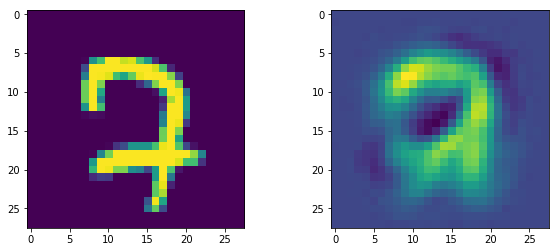

In [44]:
%matplotlib inline

x = np.random.randint(len(mnist.test.images))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(images[x].reshape(28,28))
ax2.imshow(output['reconstruction'][x].reshape(28,28))